In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Clean_NoNeg.csv')

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Rename columns to meet Prophet's requirements
# Prophet requires the columns to be named 'ds' for the datestamp and 'y' for the metric to forecast
prophet_df = df.rename(columns={'date': 'ds', 'Real Oil Prices': 'y'})

# Display the first few rows of the DataFrame
prophet_df.head()

,ds,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,y
0,1992-03-01,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,...,4.065979,2.478218,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,2.610197
1,1992-04-01,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,...,4.069727,2.481568,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,2.674989
2,1992-06-01,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,...,4.072355,2.485740,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,2.771428
3,1992-07-01,8.999322,8.850346,4.036839,13.565973,12.027287,4.154825,4.283439,4.259519,4.418656,...,4.076435,2.484907,2.623218,2.436242,4.338597,11.060620,12.169643,6.666419,2.588035,2.740955
4,1992-11-01,8.996615,8.847863,4.050880,13.569488,12.049436,4.163143,4.292269,4.269875,4.429636,...,4.087739,2.491551,2.630449,2.441477,4.446174,11.042298,12.193706,6.705386,2.680611,2.661229


## Model Training and Forecasting

06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:58 - cmdstanpy - INFO - Chain [1] done processing


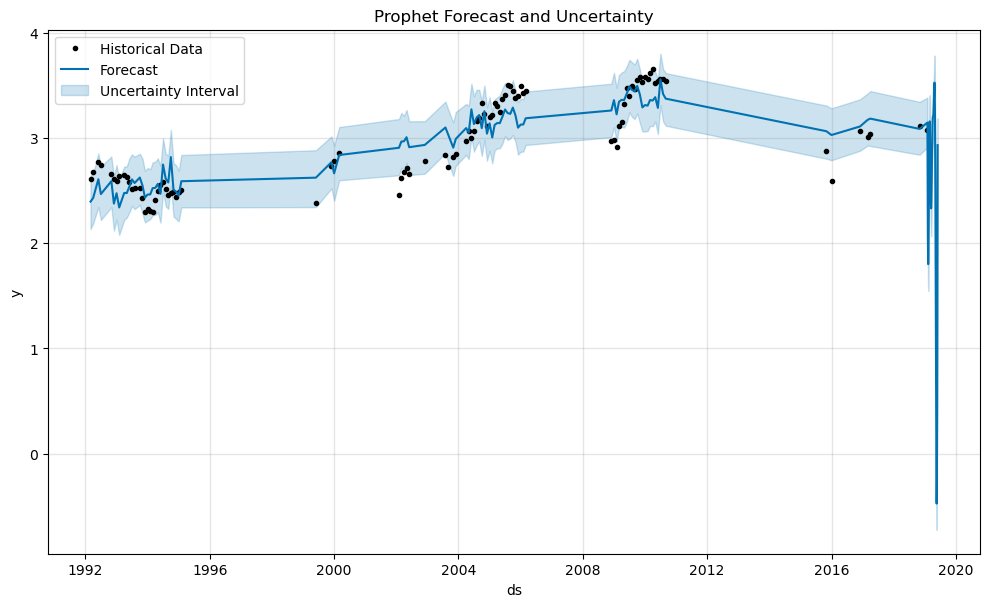

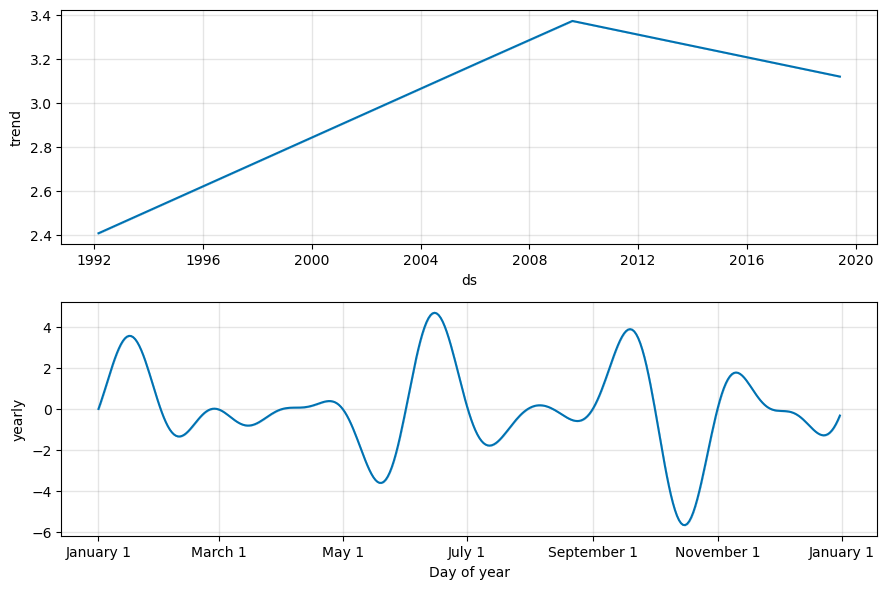

In [9]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the historical data and forecasts
fig1 = model.plot(forecast)
plt.legend(labels=['Historical Data', 'Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Prophet Forecast and Uncertainty')
plt.show()

# Plot the components of the forecast (trend, weekly, yearly)
fig2 = model.plot_components(forecast)
plt.show()

- Actual: This represents the actual data points from the dataset.
- Forecast: This is the forecasted values generated by the Prophet model for the future dates.
- Uncertainty Interval: This is the confidence interval around the forecasts, indicating the range within which the actual values are likely to fall with a certain level of confidence.

#### Parameter Tuning - `changepoint_prior_scale` which controls how sensitive the model is to potential changepoints where the trend changes.
- Higher values will make the trend more flexible, lower values will make the trend less flexible.

### Calculate Performance Metrics

In [10]:
# Calculate forecast error metrics using the historical data
y_true = prophet_df['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.20
R^2 Score: 0.77
Mean Absolute Percentage Error (MAPE): 5.71%


### Parameter Tuning for Changepoint Sensitivity

06:08:59 - cmdstanpy - INFO - Chain [1] start processing
06:09:00 - cmdstanpy - INFO - Chain [1] done processing


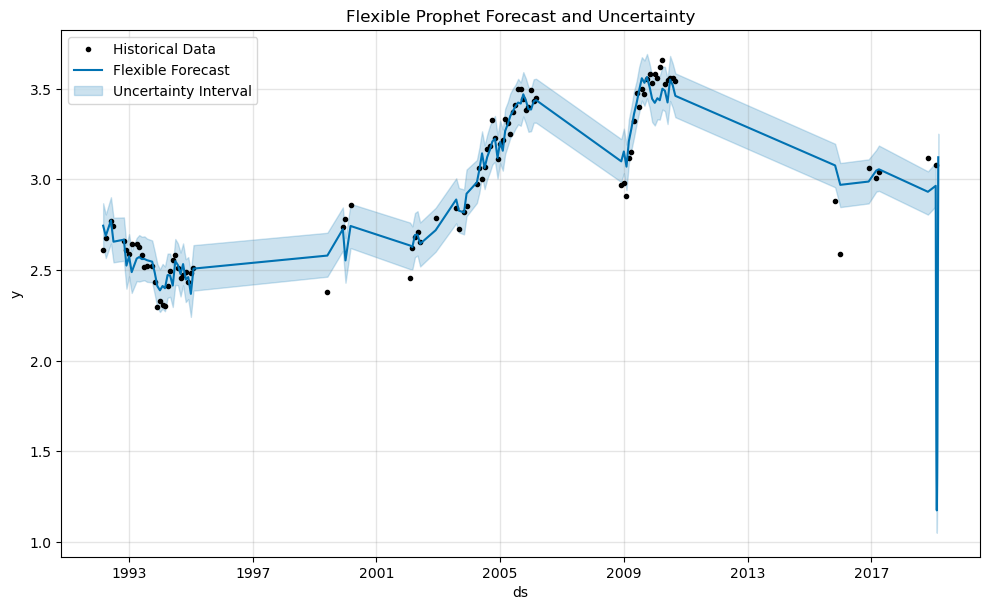

In [11]:
# Tune the changepoint_prior_scale for more flexible trend
flexible_model = Prophet(changepoint_prior_scale=0.5)
flexible_model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future_flexible = flexible_model.make_future_dataframe(periods=30)

# Generate forecasts with the flexible model
forecast_flexible = flexible_model.predict(future_flexible)

# Plot the historical data and the flexible forecasts
fig3 = flexible_model.plot(forecast_flexible)
plt.legend(labels=['Historical Data', 'Flexible Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Flexible Prophet Forecast and Uncertainty')
plt.show()

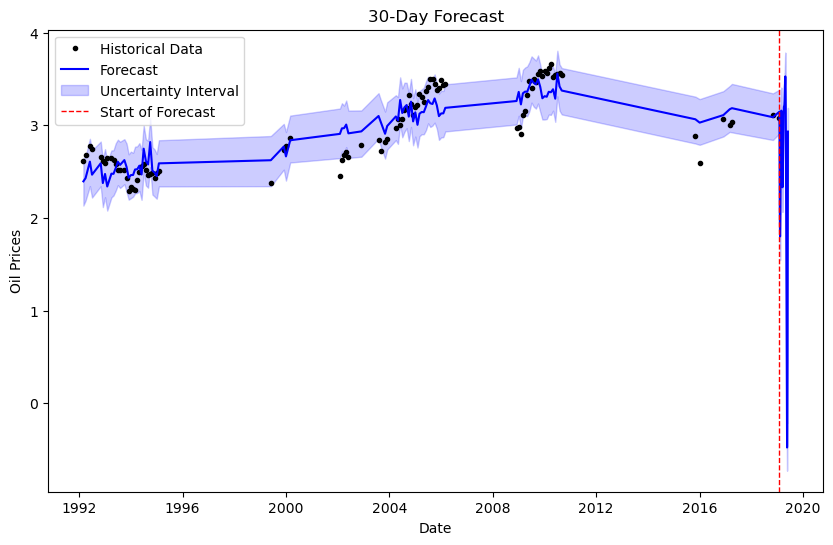

In [12]:
# Plot the forecast for the future 30-day period
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the historical data
ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Historical Data')
# Plot the predicted means as a blue line for the entire forecast period
ax.plot(forecast['ds'], forecast['yhat'], ls='-', color='blue', label='Forecast')
# Plot the prediction intervals as a shaded area for the entire forecast period
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight the 30-day prediction period with a vertical line
ax.axvline(x=prophet_df['ds'].iloc[-1], color='red', linestyle='--', lw=1, label='Start of Forecast')

# Set labels and titles
ax.set_xlabel('Date')
ax.set_ylabel('Oil Prices')
ax.set_title('30-Day Forecast')
ax.legend()

plt.show()

In [13]:
# Check the last date of historical data
last_historical_date = prophet_df['ds'].iloc[-1]
print(f"Last historical date: {last_historical_date}")

# Check the first date of forecast beyond historical data
first_forecasted_date = forecast.loc[len(prophet_df):, 'ds'].iloc[0]
print(f"First forecasted date: {first_forecasted_date}")

# Print the forecasted oil prices for the next 30 days
forecasted_values = forecast.loc[len(prophet_df):, 'yhat'].values
print(f"Forecasted values: {forecasted_values}")

# Print the forecasted oil prices for the next 30 days
forecasted_values = forecast.loc[len(prophet_df):, 'yhat'].values
print(f"Forecasted values: {forecasted_values}")


Last historical date: 2019-02-01 00:00:00
First forecasted date: 2019-02-02 00:00:00
Forecasted values: [ 2.87539558  2.62903085  2.4114445   2.22528425  2.07238156  1.95373023
  1.86948699  1.8189937   1.80082014  1.81282589  1.85223922  1.9157506
  1.99961786  2.09978003  2.21197651  2.33186805  2.45515641  2.57769915
  2.69561662  2.80538836  2.9039363   2.98869292  3.05765269  3.1094058
  3.14315368  3.15870628  3.15646179  3.13736971  3.10287894  3.05487279
  2.99559317  2.92755658  2.85346463  2.77611194  2.69829435  2.62272026
  2.55192763  2.48820929  2.43354847  2.38956646  2.35748363  2.3380948
  2.33175935  2.33840599  2.35755172  2.38833398  2.42955465  2.47973406
  2.53717316  2.60002135  2.6663477   2.73421299  2.80174006  2.86718006
  2.92897227  2.98579564  3.03661007  3.08068625  3.11762308  3.14735194
  3.17012793  3.18650835  3.19731913  3.20361056  3.20660373  3.20762978
  3.20806391  3.20925669  3.21246501  3.21878532  3.2290915   3.24397977
  3.26372282  3.2882349

In [14]:
# Check the future dates in forecast dataframe
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
212 2019-05-28  1.134355    0.883100    1.400057
213 2019-05-29  1.541276    1.301268    1.798305
214 2019-05-30  1.980816    1.702222    2.234844
215 2019-05-31  2.446797    2.193420    2.706976
216 2019-06-01  2.932454    2.686964    3.187935
